In [1]:
# !pip3 install --upgrade decorator
# !pip3 install --upgrade networkx

## Graphs Over Different `event_type`: View, Cart, Purchase

In our data analysis, we can construct various types of graphs based on different `event_type` values. These graphs capture relationships and patterns in user behavior and product interactions. The three primary types of graphs we consider are as follows:

#### Co-Occurrence Graph over PDP Views
- This graph is constructed based on the "view" event type.
- It represents the co-occurrence of Product Detail Page (PDP) views in a single user session.
- In other words, it captures sequences of PDPs viewed together by a user in the same session.

#### Co-Occurrence Graph over Products Added to Cart
- This graph is constructed based on the "cart" event type.
- It illustrates the co-occurrence of products that are added to the cart in a single user session.
- Users adding these products together to their cart suggest potential relationships or affinities.

#### Co-Occurrence Graph over Products That Are Purchased Together
- This graph is constructed based on the "purchase" event type.
- It shows the co-occurrence of products that are bought together in a single user session.
- Products frequently purchased together may indicate complementary or related items.

Each type of graph represents a distinct aspect of user behavior and product interactions. The choice of the `event_type` influences the nature of the graph and the insights it provides. These graphs are valuable for building a recommendation system that suggests products relevant to what a user is currently viewing. For example, if a user is looking at a Samsung TV, the recommendation system can utilize these graphs to suggest similar or related products, enhancing the user experience and potential sales.

---

In [2]:
# Improting libraries
import pandas as pd
import numpy as np
import duckdb
import time
import networkx as nx
import matplotlib.pyplot as plt

start = time.time()

# Connecting with duckdb database
con = duckdb.connect(database=':memory:', read_only=False)

---

## Query for Session with more than 1 pdp view

In [3]:
# Execute a SQL query to count the distinct PDP views per user session where the count is greater than 1

result = con.query('''
SELECT 
    user_session, 
    count(distinct product_id) as count_pdp_views_per_session
FROM '../Data/optimised_raw_data.parquet'
WHERE event_type = 'view'
  AND user_session IS NOT NULL
  AND product_id IS NOT NULL
GROUP BY user_session
HAVING count(distinct product_id) > 1
''').df()

result


,user_session,count_pdp_views_per_session
0,69b5d72f-fd6e-4fed-aa23-1286b2ca89a0,8
1,7f596032-ccbf-4643-9bad-e36a209512b4,4
2,31b7d4cf-dfac-4895-9927-90fa3254f860,2
3,c161400e-630b-4b59-8797-d9b9714444bf,2
4,44ca9bc7-3ba8-4546-bdf5-10b2172ed883,2
...,...,...
5340110,3df590c0-e667-4f5a-aa87-f47749cd6408,2
5340111,e1252736-1d34-40c5-8aab-af2e5bff3201,2
5340112,21f46782-fb36-4d5c-82d4-6dc26ae93fad,2
5340113,4d614d05-3b0c-4504-a75e-9e09715f737f,3


- #### There are 7Million+ sessions with more than 1 pdp view and 5M+ are distinct product views more than 1

In [4]:
# Create a table 'product_view_tbl' using a SQL query
# The table contains selected columns and filters from the Parquet file.

result = con.execute('''
CREATE TABLE product_view_tbl AS
SELECT 
    user_id,
    product_id, 
    CAST(event_time[:-3] as DATETIME) as event_time, 
    user_session
FROM '../Data/optimised_raw_data.parquet'
WHERE user_session in (SELECT 
                        user_session
                    FROM '../Data/optimised_raw_data.parquet'
                    WHERE event_type = 'view'
                      AND user_session IS NOT NULL
                      AND product_id IS NOT NULL
                    GROUP BY user_session
                    HAVING count(distinct product_id) > 1)
ORDER BY user_session, CAST(event_time[:-3] as DATETIME)
''').df()

result


,Count
0,43408767


In [5]:
# Execute a SQL query to select records from the 'product_view_tbl' table
# where the 'user_session' is equal to '29e0ff8c-d2c0-474b-b02b-8a17445100c8'

result = con.query("""
SELECT *
FROM product_view_tbl
WHERE user_session = '29e0ff8c-d2c0-474b-b02b-8a17445100c8'
""").df()

result


,user_id,product_id,event_time,user_session
0,519798087,26201121,2020-01-01 00:00:11,29e0ff8c-d2c0-474b-b02b-8a17445100c8
1,519798087,26204318,2020-01-01 00:00:42,29e0ff8c-d2c0-474b-b02b-8a17445100c8
2,519798087,26200951,2020-01-01 00:01:14,29e0ff8c-d2c0-474b-b02b-8a17445100c8
3,519798087,26200951,2020-01-01 00:01:27,29e0ff8c-d2c0-474b-b02b-8a17445100c8
4,519798087,26203272,2020-01-01 00:01:46,29e0ff8c-d2c0-474b-b02b-8a17445100c8
5,519798087,26203272,2020-01-01 00:02:01,29e0ff8c-d2c0-474b-b02b-8a17445100c8
6,519798087,26201124,2020-01-01 00:02:29,29e0ff8c-d2c0-474b-b02b-8a17445100c8
7,519798087,26201124,2020-01-01 00:02:35,29e0ff8c-d2c0-474b-b02b-8a17445100c8
8,519798087,26200344,2020-01-01 00:03:27,29e0ff8c-d2c0-474b-b02b-8a17445100c8
9,519798087,100037882,2020-01-01 00:04:04,29e0ff8c-d2c0-474b-b02b-8a17445100c8


In [6]:
# Execute a SQL query to create a sub-graph from the 'product_view_tbl' table
# for a specific 'user_session' ('29e0ff8c-d2c0-474b-b02b-8a17445100c8')

sub_graph = con.query("""
SELECT 
    product_id,
    LEAD(product_id, 1, -1) OVER (PARTITION BY user_session ORDER BY event_time) AS next_viewed_product_id,
    user_session,
    event_time
FROM product_view_tbl
WHERE user_session = '29e0ff8c-d2c0-474b-b02b-8a17445100c8'
""").df()

sub_graph


,product_id,next_viewed_product_id,user_session,event_time
0,26201121,26204318,29e0ff8c-d2c0-474b-b02b-8a17445100c8,2020-01-01 00:00:11
1,26204318,26200951,29e0ff8c-d2c0-474b-b02b-8a17445100c8,2020-01-01 00:00:42
2,26200951,26200951,29e0ff8c-d2c0-474b-b02b-8a17445100c8,2020-01-01 00:01:14
3,26200951,26203272,29e0ff8c-d2c0-474b-b02b-8a17445100c8,2020-01-01 00:01:27
4,26203272,26203272,29e0ff8c-d2c0-474b-b02b-8a17445100c8,2020-01-01 00:01:46
5,26203272,26201124,29e0ff8c-d2c0-474b-b02b-8a17445100c8,2020-01-01 00:02:01
6,26201124,26201124,29e0ff8c-d2c0-474b-b02b-8a17445100c8,2020-01-01 00:02:29
7,26201124,26200344,29e0ff8c-d2c0-474b-b02b-8a17445100c8,2020-01-01 00:02:35
8,26200344,100037882,29e0ff8c-d2c0-474b-b02b-8a17445100c8,2020-01-01 00:03:27
9,100037882,100037882,29e0ff8c-d2c0-474b-b02b-8a17445100c8,2020-01-01 00:04:04


In [7]:
# Create an edge list from the 'sub_graph' DataFrame

# Extract the 'product_id' and 'next_viewed_product_id' columns from the 'sub_graph' DataFrame
edge_list = [[x[0], x[1]] for x in sub_graph[['product_id', 'next_viewed_product_id']].to_numpy()]

edge_list

[[26201121, 26204318],
 [26204318, 26200951],
 [26200951, 26200951],
 [26200951, 26203272],
 [26203272, 26203272],
 [26203272, 26201124],
 [26201124, 26201124],
 [26201124, 26200344],
 [26200344, 100037882],
 [100037882, 100037882],
 [100037882, 26204653],
 [26204653, 26202732],
 [26202732, 100000092],
 [100000092, -1]]

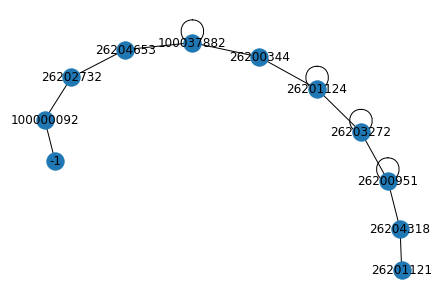

In [8]:
# Create a NetworkX graph and add edges from the 'edge_list'

# Create an empty undirected graph using NetworkX.
G = nx.Graph()

# Add edges to the graph using the 'edge_list'.
G.add_edges_from(edge_list)

# Draw the graph with labels (nodes will be labeled).
nx.draw(G, with_labels=True)

plt.show()


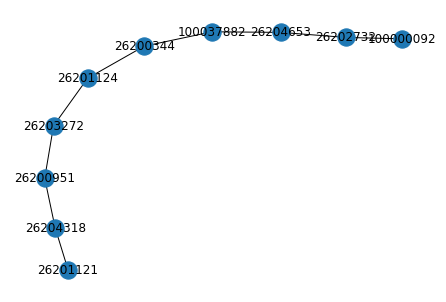

In [9]:
# Execute a SQL query to create a sub-graph based on the 'product_view_tbl' for a specific 'user_session'.
# The sub-graph is formed by selecting 'product_id' and 'next_viewed_product_id' where the two values are not equal and 'next_viewed_product_id' is not -1.
sub_graph = con.query("""
SELECT * FROM (SELECT 
       product_id,
       LEAD(product_id, 1, -1) OVER (PARTITION BY user_session ORDER BY event_time) AS next_viewed_product_id,
        user_session,
        event_time
FROM product_view_tbl
WHERE user_session = '29e0ff8c-d2c0-474b-b02b-8a17445100c8' ) as A where product_id<>next_viewed_product_id and next_viewed_product_id<>-1
""").df()

# Extract 'product_id' and 'next_viewed_product_id' columns to create an edge list.
edge_list = [[x[0], x[1]] for x in sub_graph[['product_id', 'next_viewed_product_id']].to_numpy()]

# Create an empty undirected graph using NetworkX and add edges from the 'edge_list'.
G = nx.Graph()
G.add_edges_from(edge_list)

# Draw the graph with labels (nodes will be labeled).
nx.draw(G, with_labels=True)

plt.show()


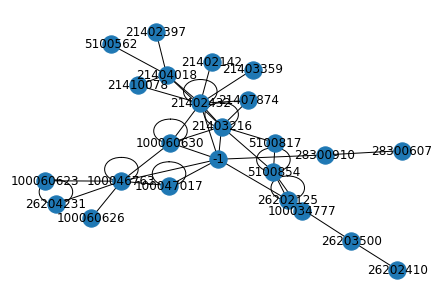

In [10]:
# Execute a SQL query to create a sub-graph based on the 'product_view_tbl' for a specific 'user_id'.
sub_graph = con.query("""SELECT 
       product_id,
       LEAD(product_id, 1, -1) OVER (PARTITION BY user_session ORDER BY event_time) AS next_viewed_product_id,
        user_session,
        event_time
FROM product_view_tbl
WHERE user_id = '518269232'""").df()

# Extract 'product_id' and 'next_viewed_product_id' columns to create an edge list.
edge_list = [[x[0], x[1]] for x in sub_graph[['product_id', 'next_viewed_product_id']].to_numpy()]

# Create an empty undirected graph using NetworkX and add edges from the 'edge_list'.
G = nx.Graph()
G.add_edges_from(edge_list)

# Draw the graph with labels (nodes will be labeled).
nx.draw(G, with_labels=True)

plt.show()


In [11]:
# Execute a SQL query to create a table 'product_views_graph' by selecting specific columns from 'product_view_tbl'
# The query also calculates the 'next_viewed_product_id' using the LEAD() window function.

result = con.execute("""CREATE TABLE product_views_graph AS select product_id, 
LEAD(product_id, 1, -1) OVER (PARTITION BY user_session ORDER BY event_time) as next_viewed_product_id,
user_session,
event_time
from product_view_tbl
""").df()

result


CPU times: user 12min 53s, sys: 3min 7s, total: 16min
Wall time: 2min 19s


,Count
0,43408767


In [12]:
# Execute a SQL query to select the first 15 rows from the 'product_views_graph' table

result = con.query("""SELECT * FROM product_views_graph LIMIT 15""").df()

result

,product_id,next_viewed_product_id,user_session,event_time
0,1004225,1004226,000392dd-5930-4971-b083-70a2c41a2a4e,2020-01-22 13:39:58
1,1004226,-1,000392dd-5930-4971-b083-70a2c41a2a4e,2020-01-22 13:41:22
2,1004873,1005014,00212826-722c-420e-afd8-d9c54da2a7a7,2020-01-17 10:30:45
3,1005014,-1,00212826-722c-420e-afd8-d9c54da2a7a7,2020-01-17 10:31:14
4,14300248,14300048,00242419-7744-4cc2-9057-5c12b4da24fc,2020-01-09 15:31:53
5,14300048,-1,00242419-7744-4cc2-9057-5c12b4da24fc,2020-01-09 15:34:52
6,1004536,1004536,003431c5-3738-41a0-9a1c-d3aca6f7999f,2020-01-11 16:46:42
7,1004536,1004849,003431c5-3738-41a0-9a1c-d3aca6f7999f,2020-01-11 16:58:56
8,1004849,1004849,003431c5-3738-41a0-9a1c-d3aca6f7999f,2020-01-11 16:59:19
9,1004849,1003771,003431c5-3738-41a0-9a1c-d3aca6f7999f,2020-01-11 16:59:44


---

## COUNT of Cases: Refresh on Same Product Page

In [13]:
# Execute a SQL query to count the number of rows where 'product_id' is equal to 'next_viewed_product_id' in the 'product_views_graph' table.
result = con.query("""SELECT COUNT(*) as page_refresh_count FROM product_views_graph 
WHERE product_id=next_viewed_product_id""").df()

result


,page_refresh_count
0,12181069


In [14]:
# Measure the execution time of the following code using %%time
%%time

# Execute a SQL query to create a directed graph (edge list) by selecting specific columns from 'product_views_graph'
# The query filters out cases where 'product_id' is equal to 'next_viewed_product_id' and where 'next_viewed_product_id' is -1.

# The 'con.execute' method runs the SQL query using the DuckDB connection.
directed_graph = con.execute("""SELECT product_id AS pid_1,
       next_viewed_product_id AS pid_2
FROM product_views_graph
WHERE product_id!=next_viewed_product_id
  AND next_viewed_product_id<>-1
""").df()


CPU times: user 1.92 s, sys: 528 ms, total: 2.45 s
Wall time: 2.48 s


In [15]:
len(directed_graph)

25887583

In [16]:
# Save the 'directed_graph' DataFrame to a Parquet file
# The file will be saved at the specified path without including the index.
directed_graph.to_parquet('../Data/ConstructedGraph/raw_unweighted_directed_product_views_graph.parquet', index=False)



In [17]:
directed_graph

,pid_1,pid_2
0,1004225,1004226
1,1004873,1005014
2,14300248,14300048
3,1004536,1004849
4,1004849,1003771
...,...,...
25887578,26203856,26200308
25887579,26200308,26201813
25887580,5100376,5100846
25887581,5100846,1005160


---

## Directed_Weighted_Product View Graph

In [18]:
# Measure the execution time of the following code using %%time
%%time

# Execute a SQL query to create a directed weighted graph by selecting specific columns from 'product_views_graph'
# The query also calculates the count of occurrences ('occurence_ct') for each pair of 'pid_1' and 'pid_2'.

directed_weighted_graph = con.execute("""
SELECT product_id AS pid_1,
       next_viewed_product_id AS pid_2,
       COUNT(*) AS occurence_ct
FROM product_views_graph
WHERE next_viewed_product_id<>-1
  AND product_id IS NOT NULL
  AND product_id != next_viewed_product_id
GROUP BY 1,
         2
""").df()


CPU times: user 20.2 s, sys: 2.58 s, total: 22.8 s
Wall time: 3.72 s


In [19]:
directed_weighted_graph

,pid_1,pid_2,occurence_ct
0,100065890,6700760,15
1,9100130,9101275,1
2,5301435,5300864,16
3,5301397,5301187,12
4,5301435,5301380,25
...,...,...,...
8418450,100076414,100076376,1
8418451,12201948,12201658,1
8418452,16000766,15902624,1
8418453,15902640,15902508,1


In [20]:
# Save the 'directed_weighted_graph' DataFrame to a Parquet file
# The file will be saved at the specified path without including the index.
directed_weighted_graph.to_parquet('../Data/ConstructedGraph/directed_weighted_product_views_graph.parquet', index=False)


---

## Undirected Weighted Product View Graph

In [21]:
# Measure the execution time of the following code using %%time
%%time

# Execute a SQL query to create an undirected weighted graph by selecting specific columns from 'product_views_graph'
# The query also calculates the count of occurrences ('occurence_ct') for each pair of 'pid_1' and 'pid_2'.

undirected_weighted_graph = con.execute("""
SELECT CASE
           WHEN product_id > next_viewed_product_id THEN product_id
           ELSE next_viewed_product_id
       END AS pid_1,
       CASE
           WHEN product_id < next_viewed_product_id THEN product_id
           ELSE next_viewed_product_id
       END AS pid_2,
       COUNT(*) AS occurence_ct
FROM product_views_graph
WHERE next_viewed_product_id<>-1
  AND product_id IS NOT NULL
  AND product_id != next_viewed_product_id
GROUP BY 1,
         2
""").df()


CPU times: user 20.9 s, sys: 2.34 s, total: 23.2 s
Wall time: 3.71 s


In [22]:
undirected_weighted_graph

,pid_1,pid_2,occurence_ct
0,3601512,3601269,37
1,100059274,3601306,12
2,5100855,4804056,880
3,100041977,100041934,2
4,100057579,100057560,11
...,...,...,...
6846587,12300752,4803895,1
6846588,100017063,6501098,1
6846589,8800741,1005195,1
6846590,25200369,23900098,1


In [23]:
# Save the 'undirected_weighted_graph' DataFrame to a Parquet file
# The file will be saved at the specified path without including the index.
undirected_weighted_graph.to_parquet('../Data/ConstructedGraph/undirected_weighted_product_views_graph.parquet', index=False)


In [24]:
# Calculate and print the total execution time in minutes

# Calculate the time taken by subtracting 'start' from the current time.
elapsed_time_in_seconds = time.time() - start

# Convert the elapsed time to minutes and round to two decimal places.
elapsed_time_in_minutes = round(elapsed_time_in_seconds / 60, 2)

# Print the total execution time in minutes.
print("Process Took: {}mins".format(elapsed_time_in_minutes))


Process Took: 14.6mins


---